# Stacking

In [24]:
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv('Data/X_train.csv', index_col='building_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='building_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='building_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='building_id')

In [3]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Divide Columns and drop unimportant features

As before, I'll divide the columns for the Pipeline and drop unimportant features.

In [4]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [5]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

### Pipelines

The plan is to use Random Forest and KNN as the estimators and LogisticRegression as the final estimator in the stacked model.  First, I will need to create pipelines for the various column transformations for RF and KNN.

In [31]:
def log_transform(x):
    return np.log(x+1)

In [11]:
#Create the intial Pipelines for OHE, Target Encoding, log transform, and Standard Scaler
ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

function_transformer = FunctionTransformer(log_transform)
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())])

In [16]:
#Create the Random Forest ColumnTransformer and final pipeline
rf_preprocessor = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('integer', 'passthrough', integer_cols),
    ('geo', target_pipe, geo_cols)
])

rf_pipe = imbPipeline([
    ('rf_preprocessor', rf_preprocessor),
    ('rf', RandomForestClassifier(max_depth=50, min_samples_split=10, n_jobs=-1, random_state=42))
])

In [17]:
#Create the KNN ColumnTransformer and final pipeline
knn_preprocessor = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', target_pipe, geo_cols),
    ('integer', integer_pipe, integer_cols),
])

knn_pipe = imbPipeline([
    ('knn_preprocessor', knn_preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=75, p=1, n_jobs=-1))
])

### Create the Stacking Classifer

In [25]:
estimators = [('rf', rf_pipe),
              ('knn', knn_pipe)]
final_estimator = LogisticRegression(C=.01, solver='saga', n_jobs=-1, random_state=42)

stacked = StackingClassifier(estimators=estimators, final_estimator=final_estimator, n_jobs=-1, verbose=2)

### Fit the stacked models and score on the test data

In [28]:
start = time.time()
stacked.fit(X_train, y_train)
end = time.time()
print(f'Runtime: {end-start} seconds')

Runtime: 1615.3519928455353 seconds


In [29]:
stacked_preds = stacked.predict(X_test)
stacked_score = f1_score(y_test, stacked_preds, average='micro')
stacked_score

0.7450384491412257

The stacked model performs comprably to the stand alone RF classifier, with a slightly lower score on the test data. Since the stacked model is more complex, I'll consider the stand alone Random Forest model as superior.

### Plot confusion matrix and check model's target accuracies

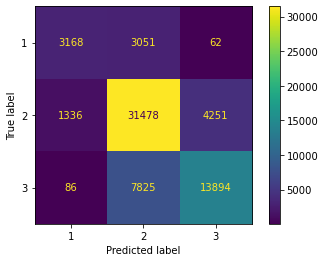

In [33]:
plot_confusion_matrix(stacked, X_test, y_test);

In [34]:
cm = confusion_matrix(y_test, stacked_preds)
low_damage = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
medium_damage = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
complete_destruction = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(low_damage*100, 2)}% of low damage.')
print(f'The model correctly predicts {round(medium_damage*100, 2)}% of medium damage.')
print(f'The model correctly predicts {round(complete_destruction*100, 2)}% of complete destruction.')

The model correctly predicts 50.44% of low damage.
The model correctly predicts 84.93% of medium damage.
The model correctly predicts 63.72% of complete destruction.
